#Logistic Regression (cat recognizer)

In this exercise you will build a logistic regression classifier to recognize cats. 

**Instructions:**
- Do not use loops (for/while) in your code, unless the instructions explicitly ask you to do so.

**You will learn to:**
- how to preprocess digital images prior to feeding into the model
- build the whole algorithm from scratch again (you've already done this during the previous exercise. So mainly you are goint to copy/pasty and make sure that all the pieces work together)

**Notes:**
- I am not going to write detailed comments to parts that you are already familiar with. Though if you need to refresh you memory, skim the files of previous exercises 
- The dataset is given in 'h5' format. You don't need to know anything specific about that format, everything is done for you in the 'load_dataset' function.

##Overview of the problem
**Problem Statement**: You are given a dataset ("data.h5") containing:
- a training set of m_train images labeled as cat (y=1) or non-cat (y=0)
- each image is of shape (num_px, num_px, 3) where 3 is for the 3 channels (RGB). Thus, each image is square (height = num_px) and (width = num_px).

You will build a simple image-recognition algorithm that can correctly classify pictures as cat or non-cat.

Let's get more familiar with the dataset. Load the data by running the code of the below section.

##Importing and Visualizing Data

In [1]:
#provide Colab access to Google Drive 
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import pandas as pd
import torch
import matplotlib.pyplot as plt

In [0]:
# our training dataset is in h5py format. To be able work with it let's import the corresponding library.
import h5py

In [0]:
def load_dataset():
  train_dataset = h5py.File('/content/drive/My Drive/AI/Cat/train_catvnoncat.h5', "r")
  
  train_set_x_orig = torch.from_numpy(train_dataset["train_set_x"][:]).float() # your train set features
  train_set_y_orig = torch.from_numpy(train_dataset["train_set_y"][:]).float() # your train set labels
  
  train_set_y_orig = train_set_y_orig.reshape((train_set_y_orig.shape[0], 1)) #you could also use unsqueeze method here
    
  return train_set_x_orig, train_set_y_orig

In [0]:
# Loading the data (cat/non-cat)
train_set_x_orig, y = load_dataset()

We added "_orig" at the end of image datasets (train and test) because we are going to preprocess them. After preprocessing, we will end up with train_set_x (the labels train_set_y don't need any preprocessing).

Each line of your train_set_x_orig is an array representing an image. You can visualize an example by running the following code. Feel free also to change the index value and re-run to see other images

cat


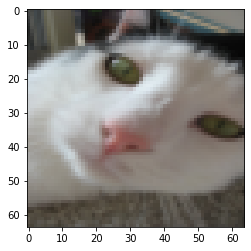

In [6]:
# Example of a picture
index = 14
plt.imshow(train_set_x_orig[index].int())
print ("cat" if y[index, :] == 1. else "non-cat")

##Understanding the structure of RGB images and our dataset

To be able to classify images, one, first, needs to understand the structure of digital images. Please follow this [link](http://geraldbakker.nl/psnumbers/rgb-explained.html) to read, or this [link](https://youtu.be/15aqFQQVBWU) to watch a youtube video about digital images and their structure. (If it is still not clear, there are tons of other resources on internet, feel free to browse and learn more)

In [7]:
#Let's call 'shape' method and see what we have
train_set_x_orig.shape

torch.Size([209, 64, 64, 3])

We see that the shape of our dataset is [209, 64, 64, 3]. Let's understand what these numbers mean. Basically it is a 4-dimensional tensor. As in previous datasets, the first index shows the number of training examples in a dataset. In our dataset we have 209 training examples (images). Then comes a triplet of numbers that describes each individual image. You already know that images on internet are stored in RGB format. In a nutshel, each image is a 3D tensor, that is a group of three layers (matrices) stocked one on another. Each layer represents intencitis of a specific color chanel (red, green, or blue) in each of the pixels. So, in our particular example, we have images of 64x64 size. 64 pixels in width, and 64 pixels in height. Each pixel has an intensity ranging from 0 to 255. So, for example, to learn the intensity of the red color of the last pixel in first row of the 45-th image we put the following indeces: [44, 0, 63, 0]. (Remember that the indexing in pytorch tensors start from '0'). 

Hopefully, now you understand the structure of our dataset. But, in order to feed the dataset into our algorithm, we have to reshape it. How? For each individual image, we need to stock all the rows of each of the 3 matrices (color channels) in one giant row. Let's say we have a tiny image [2,2,3] (image 2x2 with 3 chanels): red channel - [[23,144], [137, 0]], green channel - [[78, 100],[188, 19]], and blue channel - [[90, 11], [0, 238]]. We want to reshape it to get the following vector: [23, 144, 137, 0, 78, 100, 188, 19, 90, 11, 0, 238]. This operation resulted in a vector of length 12. In our particula case we'll have 64x64x3 = 12,288 features. After reshaping all the images we'll have a matrix of the following shape : [209, 12288] - 209 training examples of length 12288. In other words, each image is defined by 12288 features (intencities of each of the channel pixel). The below code reshapes our dataset: 

In [8]:
# Reshape the training and test examples

train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1)

print ("train_set_x_flatten shape: " + str(train_set_x_flatten.shape))
print ("train_set_y shape: " + str(y.shape))

train_set_x_flatten shape: torch.Size([209, 12288])
train_set_y shape: torch.Size([209, 1])


In [0]:
#Feature scaling: since the values of each of the feature is >= 0, and the max value is 255, it is enough to just devide the values of each of the features by 255. 
X = train_set_x_flatten/255.

In [10]:
X.shape

torch.Size([209, 12288])

Our dataset is of shape [209, 12288]: 209 training examples, each of which consists of values for 12288 features. 
Now, you need to build a classifier that will recognize, whether it is a cat image or not. Implement each of the helper functions and train the model. 

###Helper functions

In [0]:
def sigmoid(z):
  #Code here
  s = 1/(1 + torch.exp(-z))
  return s

In [0]:
def initialize_with_zeros(dim):
  #Code here
  w = torch.zeros(1, dim)
  b = 0  
  assert(w.shape == (1, dim))   
  return w, b

In [0]:
def cost_fn(a, y):
  #Code here
  m = y.numel()
  J = (-y.t()@torch.log(a) - (1-y).t()@torch.log(1-a))/m  
  return J

In [0]:
def model(X, w, b): 
  #Code here
  z = X@w.t() + b
  a = sigmoid(z)
  return a

In [0]:
def backward(X, a, y):
  #Code here 
  m = y.numel()
  dw = ((a - y).t()@X)/m
  db = ((a - y).sum())/m 
  return dw, db

In [0]:
def predict(X, w, b):
  A = model(X, w, b)
  Y_prediction = A > 0.5       
        
  return Y_prediction.float()

In [0]:
def train (X, y, epochs, lr):
   
  J_history = []
  
  w, b = initialize_with_zeros(X.shape[1])

  for i in range(epochs):
    #code here
    # Forward pass:
    preds = model(X, w, b)         # calculate the predictions for the current values of w and b
    J = cost_fn(preds, y)       # calculate the loss - value of the cost function for the current values of w and b
    #Backward pass:
    dw, db = backward(X, preds, y) # calculate the partial derivatives dw and db
    w -=  alpha*dw                    # update the values of w 
    b -=  alpha*db                    # update the value b

    if (i%10 == 0):
      J_history.append(J)
  
  return w, b, J_history 

In [0]:
alpha = 0.001
epochs = 4000
#please see the last sell for some analysis

In [19]:
%time w, b, J_h = train(X, y, epochs, alpha)

CPU times: user 4.62 s, sys: 1.48 ms, total: 4.62 s
Wall time: 4.62 s


In [0]:
Y_prediction_train = predict(X, w, b)

In [21]:
# Print train/test Errors
print("train accuracy: {} %".format(100 - torch.mean(torch.abs(Y_prediction_train - y)) * 100))

train accuracy: 95.69377899169922 %


**Expected output**
                                            
                                            **train accuracy**  99.0430603

tensor([[0.2445]])


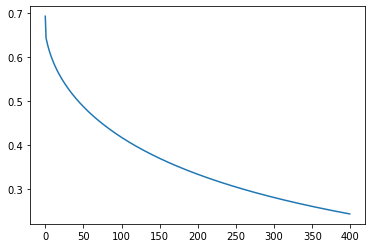

In [22]:
import matplotlib.pyplot as plt
print(J_h[-1])
plt.plot(J_h)

**Testing**
                                            
                                            Importing test data and calculating the accuracy
                                             

In [0]:
def load_test_dataset():
  test_dataset = h5py.File('/content/drive/My Drive/AI/Cat/test_catvnoncat.h5', "r")
  
  test_set_x_orig = torch.from_numpy(test_dataset["test_set_x"][:]).float() # your train set features
  test_set_y_orig = torch.from_numpy(test_dataset["test_set_y"][:]).float() # your train set labels
  
  test_set_y_orig = test_set_y_orig.reshape((test_set_y_orig.shape[0], 1)) #you could also use unsqueeze method here
    
  return test_set_x_orig, test_set_y_orig

In [24]:
test_x, test_y = load_test_dataset()

test_data = test_x.reshape(test_x.shape[0], -1)/255
predictions_test = predict(test_data, w, b )

print("test accuracy: {} %".format(100 - torch.mean(torch.abs(predictions_test - test_y)) * 100))

test accuracy: 74.0 %
